# Objectives 

The objective of this project is to select the p,d, and q values for an ARIMA model, explore alternate models, and ultimately select a final model for Walmart stock data to predict the Adjusted Close values for the next quarter.

# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs
# Set wide fig size for plots
plt.rcParams['figure.figsize'] = (12,3)

# Custom Functions

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    
    fig, ax = plt.subplots(figsize=figsize)

    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [3]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)

    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    if annotate_seas == True:
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        n_seasons = nlags//m 

        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

# Load Data

In [6]:
# Load in stock data
ts =  pd.read_csv('Data/WMT.csv',parse_dates=['Date'],index_col='Date')
ts.head()

,Adj Close
Date,
2000-01-03,44.915394
2000-01-04,43.234756
2000-01-05,42.352402
2000-01-06,42.814564
2000-01-07,46.049828


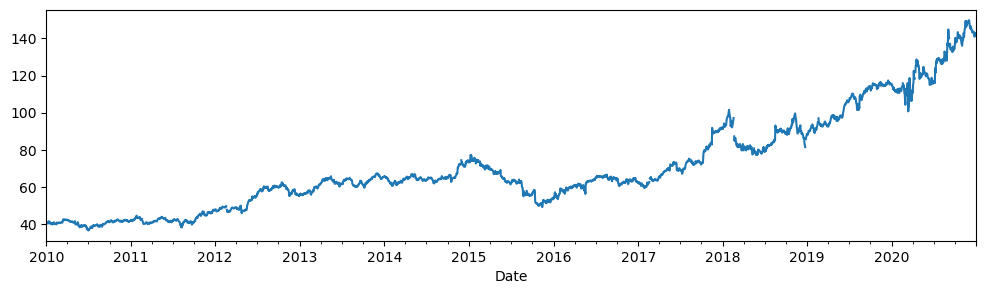

In [7]:
# Filter for 2010 to 2020 to predict the Adjusted Close values for the next quarter.
ts = ts.loc['2010':'2020','Adj Close']
ts.plot();

In [8]:
# Resample dataframe with a business day frequency ('B')
ts = ts.resample('B').asfreq()
ts

Date
2010-01-01           NaN
2010-01-04     40.963638
2010-01-05     40.555729
2010-01-06     40.465084
2010-01-07     40.487759
                 ...    
2020-12-25           NaN
2020-12-28    142.946777
2020-12-29    142.041183
2020-12-30    141.923065
2020-12-31    141.893524
Freq: B, Name: Adj Close, Length: 2870, dtype: float64

In [9]:
# Check for null values
ts.isna().sum()

101

In [10]:
# Look at the first 20 null values and try to understand where the null values are coming from 
# before determining a method of addressing them.
null = ts.isna()
ts[null].head(20)

Date
2010-01-01   NaN
2010-01-18   NaN
2010-02-15   NaN
2010-04-02   NaN
2010-05-31   NaN
2010-07-05   NaN
2010-09-06   NaN
2010-11-25   NaN
2010-12-24   NaN
2011-01-17   NaN
2011-02-21   NaN
2011-04-22   NaN
2011-05-30   NaN
2011-07-04   NaN
2011-09-05   NaN
2011-11-24   NaN
2011-12-26   NaN
2012-01-02   NaN
2012-01-16   NaN
2012-02-20   NaN
Name: Adj Close, dtype: float64

Upon inspection, the null values correspond with US holidays. Stock market is closed on holidays. Therefore, I will fill in null values with the previous value.

/var/folders/3p/yc5rv6f13xg_syq03ll5zv0c0000gn/T/ipykernel_47264/723747655.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = ts.fillna(method='ffill')


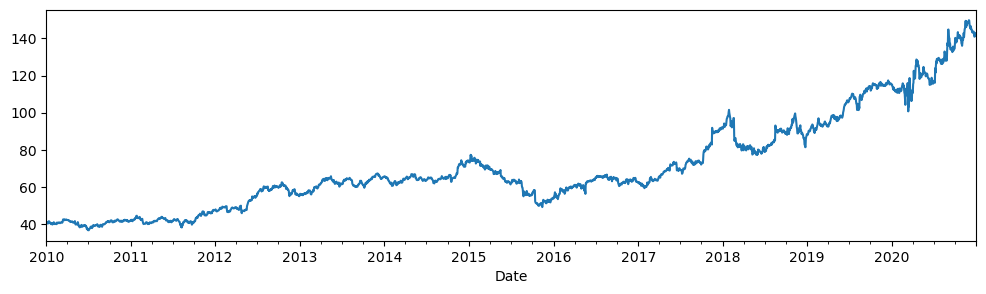

In [11]:
# Fill missing values with previous value
ts = ts.fillna(method='ffill')
ts.plot();

In [12]:
# Check to make sure null values are filled 
ts.isna().sum()

1

Since we fill the null value with the previous value, the first date 2001-01-01 does not have a previous value to fill.
I will drop this date for modeling purposes.

In [13]:
ts = ts.dropna()
ts.isna().sum()

0

# Check for Stationarity

In [14]:
# Testing the raw data for stationarity
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,1.436262,23,2845,0.997273,0.05,False


Raw data is not stationary, I will check how many differencings is sufficient to make it stationary using pmdarima's ndffs.

In [15]:
# Use ndiffs to determine differencing
d = ndiffs(ts)
print(f'd is {d}')

d is 1


The ndiffs function suggests 1 differencing is sufficient for this dataset. 

In [16]:
# 1 Differecing (d=1)
ts_diff = ts.diff().dropna()

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-12.215558,22,2845,0.0,0.05,True


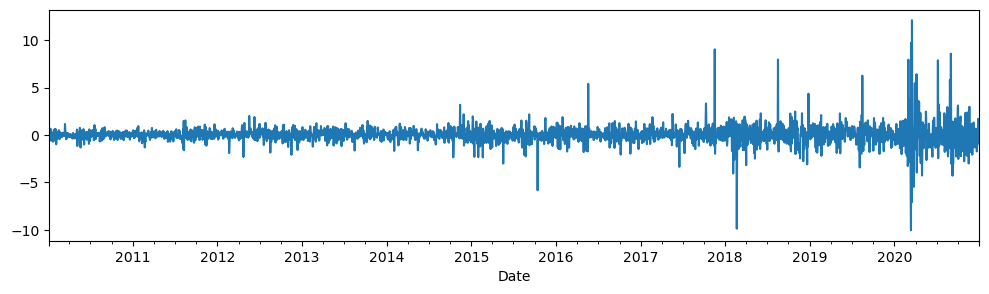

In [17]:
ts_diff.plot()
#Check it again for stationarity
get_adfuller_results(ts_diff)

After 1 differencing, the data is stationary and ready for modeling.

# Interpreting ACF and PACF

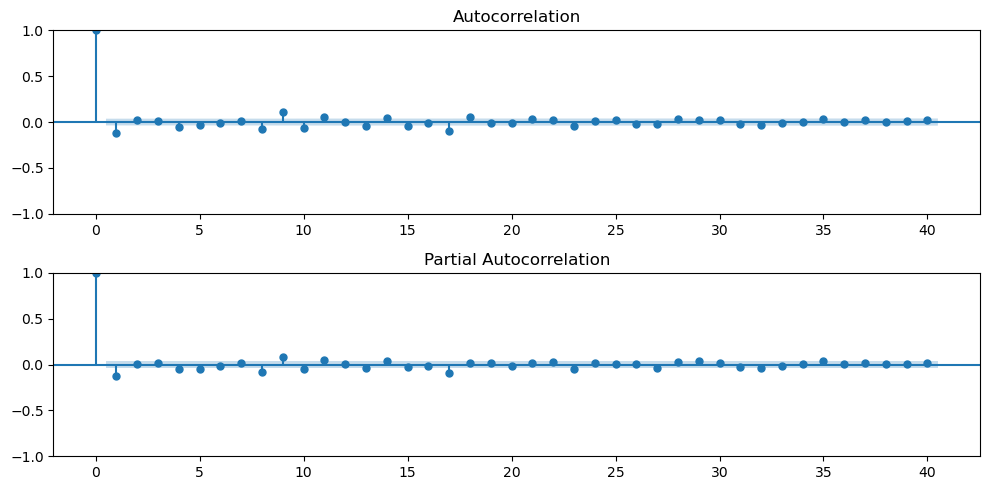

In [18]:
# Call custom functions to see both plots
plot_acf_pacf(ts_diff);

From the plots above, both ACF and the PACF as trailing, Thus we can conclude that this is an ARIMA model.
Noticed lag 1 in both plots are outside of the confidence intervals meaning they are statistically significant with a 95% confidence level. So I will start with (1,1,1).

# Train Test Split

Split the time series into training and test data. Use a test_size of one quarter (13 weeks X 5 business days)

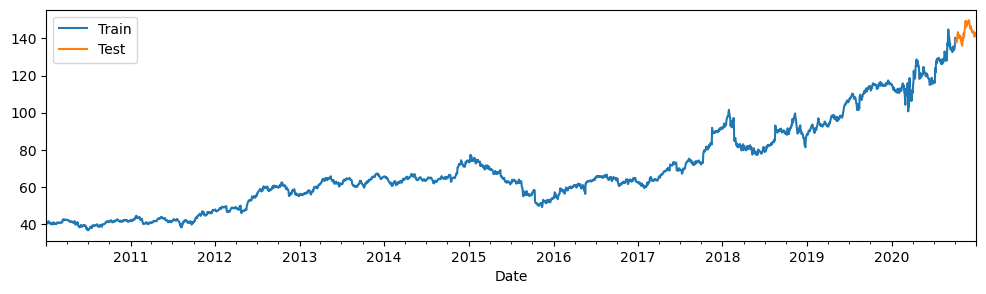

In [19]:
# Calculating the number of test lags
n_test_lags = 5*13
# Modeling to predict 3 months (1 quarter) into the future
train, test = train_test_split(ts,test_size=n_test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

# Fit and Evaluate

In [20]:
# Build the model
p = 1
d = 1
q = 1
# Define and fit the model
arima_model = tsa.ARIMA(train, order=(p,d,q)).fit()

In [21]:
# Make a forecast with the model
forecast_df = arima_model.get_forecast(len(test)).summary_frame()

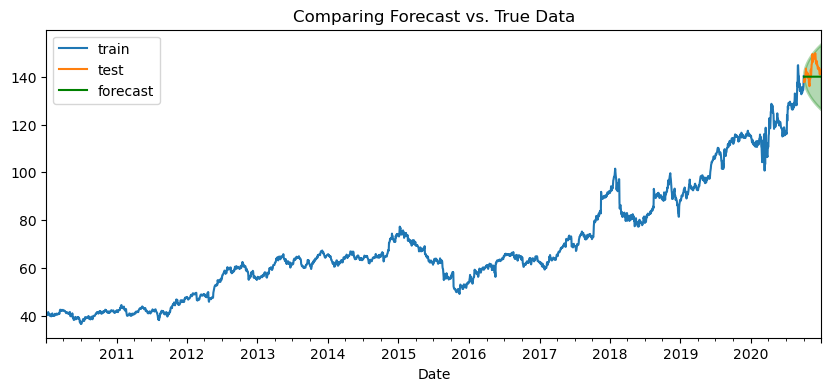

In [22]:
# Plot the forecast with true values
plot_forecast(train, test, forecast_df);

In [23]:
# Obtain metrics for evaluation.
regression_metrics_ts(test, forecast_df['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3.744
- MSE = 22.319
- RMSE = 4.724
- R^2 = -0.736
- MAPE = 2.57%


# Loop to try the combination of model orders

In [28]:
import itertools
# Define the range of values to try for p, d, q
p_value = range(0,4)
d_value = [2]
q_value = range(0,4)

# Create combinations of pdq to test
pdq_to_try = list(itertools.product(p_value,d_value,q_value))

In [29]:
best_mape = float("inf")
best_pdq = None

for pdq in pdq_to_try:
    try:
        model = tsa.ARIMA(train, order=pdq)
        result = model.fit()
        # Predict for the length of the test set
        predictions = result.predict(start=len(train), end=len(train) + len(test) - 1)

        # Calculate MAPE
        mape = mean_absolute_percentage_error(test, predictions)

        print(f"ARIMA{pdq} - MAPE: {mape}%")

        if mape < best_mape:
            best_mape = mape
            best_pdq = pdq

    except Exception as e:
        print(f"Error with model ARIMA{pdq}: {e}")
        continue

print("Best MAPE:", best_mape)
print("Best pdq:", best_pdq)

ARIMA(0, 2, 0) - MAPE: 0.6938189268730224%
ARIMA(0, 2, 1) - MAPE: 0.01849945623863988%
ARIMA(0, 2, 2) - MAPE: 0.018399315734097997%
ARIMA(0, 2, 3) - MAPE: 0.018351874088580796%
ARIMA(1, 2, 0) - MAPE: 0.6610382033101564%
ARIMA(1, 2, 1) - MAPE: 0.01836331233976533%
ARIMA(1, 2, 2) - MAPE: 0.018359394579089857%


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 2, 3) - MAPE: 0.018408568847230394%
ARIMA(2, 2, 0) - MAPE: 0.5346054646988064%
ARIMA(2, 2, 1) - MAPE: 0.018359683397029255%


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 2, 2) - MAPE: 0.01836414299152295%


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 3) - MAPE: 0.02009979470403535%
ARIMA(3, 2, 0) - MAPE: 0.4465208489373641%
ARIMA(3, 2, 1) - MAPE: 0.01835203790535255%


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(3, 2, 2) - MAPE: 0.01830126175502508%
ARIMA(3, 2, 3) - MAPE: 0.02049258407502235%
Best MAPE: 0.01830126175502508
Best pdq: (3, 2, 2)


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
best_aic = float("inf")  

best_pdq = (0,0,0)

for pdq in pdq_to_try:
    
    model = tsa.ARIMA(train, order=pdq)
                              
    result = model.fit()
    
    print(pdq, result.aic)      
    
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdq = pdq

print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)

In [34]:
# Build the model with the best AIC
p = 3
d = 2
q = 1
# Define and fit the model
ar_2_ma_3_model = tsa.ARIMA(train, order=(p,d,q)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 2.657
- MSE = 11.623
- RMSE = 3.409
- R^2 = 0.096
- MAPE = 1.84%


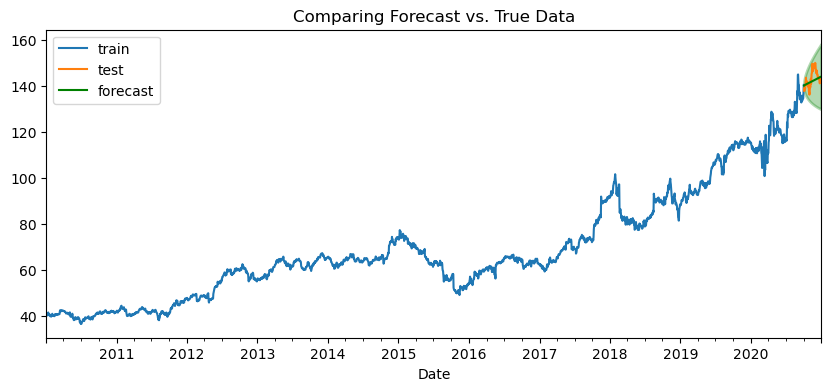

In [38]:
# Obtain summary of forecast as dataframe
forecast_df = ar_2_ma_3_model.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

Earlier when I checked for data stationarity, the pmdarima's ndffs function suggested 1 differencing would be sufficient to make the data stationary, upon further investigation and trying multiple combinations of p,d,q on the ARIMA model. 2 differencing steps yielded better MAPE scores. This might be because, with 2 differencing steps, the model captured some dynamics of the data beyond mere stationarity.  

- A MAPE of 1.84% indicates that on average the models' predictions are off by only 1.84% from the actual value. This low MAPE suggests that my model handles the data's variability well. further indicating that the model is doing an excellent job of capturing the underlying patterns and predicting future values. 

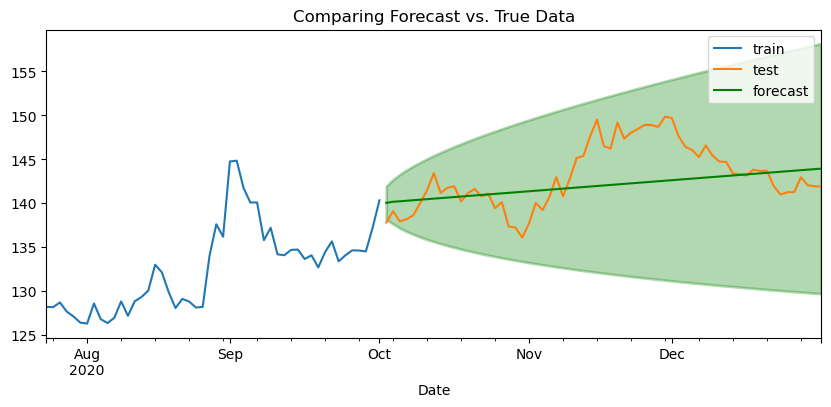

In [42]:
plot_forecast(train, test, forecast_df,n_train_lags=50);

Visually, the model appears to be performing quite well, capturing the overall trend of the test data. The direction of the forecast aligns with most of the movements in the test data. Combined with the regression metric of a 1.84% MAPE, suggest a strong model proformance. 